In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
from chronos import ChronosPipeline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
clean_data_path = r"D:\VScode WorkStation\Medical\data\clean"

patient_files = [f for f in os.listdir(clean_data_path) if f.endswith('.csv')]
patient_files = sorted(patient_files)

merged_df = pd.DataFrame()

for file_name in patient_files:
    if file_name =='merged.csv':
        continue
    file_path = os.path.join(clean_data_path, file_name)
    df = pd.read_csv(file_path)

    # 获取item_id
    item_id = file_name.split('-')[0]
    if 'item_id' not in df.columns:
        df.insert(0, 'item_id', item_id)
    
    df['timestamp'] = pd.to_datetime(df['date']) 
    df['target'] = df['y'] 
    
    # 将时间戳四舍五入到最近的整点时刻
    df['rounded_time'] = df['timestamp'].dt.round('H')
    
    # 找到每个整点时刻对应的最近原始数据点
    df_sorted = df.sort_values(['rounded_time', 'timestamp'])
    df_deduplicated = df_sorted.drop_duplicates(subset=['item_id', 'rounded_time'], keep='first')
    
    # 更新timestamp为整点时间，并保留所需列
    df_processed = df_deduplicated[['item_id', 'rounded_time', 'target']]
    df_processed = df_processed.rename(columns={'rounded_time': 'timestamp'})
    
    merged_df = pd.concat([merged_df, df_processed], ignore_index=True)
    print(f"{file_name} processed. Original rows: {len(df)}, After processing: {len(df_processed)}")

merged_df.to_csv(os.path.join(clean_data_path, 'merged.csv'), index=False)
print("Merged data saved.")

merged_df.rename(columns={'date': 'timestamp'}, inplace=True)
merged_df.rename(columns={'y': 'target'}, inplace=True)
print(merged_df.head())

LT2310KDPQ-20240828.csv processed. Original rows: 2260, After processing: 190
LT231109MQ-20240828.csv processed. Original rows: 3952, After processing: 330
LT2401MV1C-20240830.csv processed. Original rows: 4021, After processing: 336
LT2401MVLD-20240828.csv processed. Original rows: 2232, After processing: 187
LT2401MVLT-20240911.csv processed. Original rows: 2205, After processing: 185
LT2401P3JN-20240828.csv processed. Original rows: 1728, After processing: 145
LT2401P3JP-20240828.csv processed. Original rows: 4021, After processing: 336
LT2401P49L-20240828.csv processed. Original rows: 4021, After processing: 336
LT2401PQ5K-20240828.csv processed. Original rows: 3950, After processing: 330
LT2401PQLY-20240828.csv processed. Original rows: 4021, After processing: 336
Merged data saved.
      item_id           timestamp  target
0  LT2310KDPQ 2024-07-25 12:00:00    12.3
1  LT2310KDPQ 2024-07-25 13:00:00    15.1
2  LT2310KDPQ 2024-07-25 14:00:00    20.4
3  LT2310KDPQ 2024-07-25 15:00:00

In [ ]:
# 读取
data = TimeSeriesDataFrame(merged_df)
data.head()

In [2]:
clean_data_path = r"D:\VScode WorkStation\Medical\data\Data"
data = pd.read_csv(clean_data_path + '\\final_merged.csv')
data = pd.DataFrame(data)
data = TimeSeriesDataFrame(data)
data.head()

target  age gender  weight  insulin  calories  \
item_id    timestamp                                                            
LT2310KDPQ 2024-07-25 12:00:00    12.3   45      M   117.0   25.575    1800.0   
           2024-07-25 13:00:00    15.1   45      M   117.0   25.575    1800.0   
           2024-07-25 14:00:00    20.4   45      M   117.0   25.575    1800.0   
           2024-07-25 15:00:00    17.9   45      M   117.0   25.575    1800.0   
           2024-07-25 16:00:00    13.1   45      M   117.0   25.575    1800.0   

                                drug  meal_bolus  
item_id    timestamp                              
LT2310KDPQ 2024-07-25 12:00:00   NaN         8.0  
           2024-07-25 13:00:00   NaN         0.0  
           2024-07-25 14:00:00   NaN         0.0  
           2024-07-25 15:00:00   NaN         0.0  
           2024-07-25 16:00:00   NaN         0.0

In [3]:
# 自定义患者感知数据划分函数
def patient_aware_split(data, prediction_length):
    """按患者划分，保留每个患者最后prediction_length个时间点作为测试集"""
    # 确保数据已按时间排序
    data = data.sort_values(by=["item_id", "timestamp"])
    
    train_dfs = []
    test_dfs = []
    
    # 按患者分组处理
    for patient_id, patient_data in data.groupby("item_id"):
        # 计算分割点
        split_idx = max(0, len(patient_data) - prediction_length)
        
        # 划分训练测试集
        train_part = patient_data.iloc[:split_idx]
        test_part = patient_data.iloc[split_idx:]
        
        # 处理数据量不足的情况
        if len(test_part) < prediction_length:
            print(f"患者 {patient_id} 数据不足 {len(test_part)} < {prediction_length}，测试集使用所有可用数据")
        
        train_dfs.append(train_part)
        test_dfs.append(test_part)
    
    return pd.concat(train_dfs), pd.concat(test_dfs)

# 配置参数
prediction_length = 12
target_column = "target"
dynamic_covariates = ["insulin", "calories", "drug", "meal_bolus"]
static_features = ["age", "gender", "weight"]

# 执行患者感知的数据划分
train_df, test_df = patient_aware_split(data, prediction_length)

# 转换为TimeSeriesDataFrame格式
train_data = TimeSeriesDataFrame.from_data_frame(
    df=train_df,
    id_column="item_id",
    timestamp_column="timestamp",
)

test_data = TimeSeriesDataFrame.from_data_frame(
    df=test_df,
    id_column="item_id",
    timestamp_column="timestamp",
)

print("训练集最后时间戳示例:")
print(train_data.reset_index().groupby("item_id")["timestamp"].max())

# 验证预测起始时间
print("测试集起始时间示例:")
print(test_data.reset_index().groupby("item_id")["timestamp"].min())

# check_test_data = test_data.copy()
# check_test_data.to_csv("check_test_data.csv")

训练集最后时间戳示例:
item_id
LT2310KDPQ   2024-08-01 21:00:00
LT231109MQ   2024-08-17 21:00:00
LT2401MV1C   2024-08-29 09:00:00
LT2401MVLD   2024-08-26 22:00:00
LT2401MVLT   2024-08-28 22:00:00
LT2401P3JN   2024-08-19 06:00:00
LT2401P3JP   2024-08-15 01:00:00
LT2401P49L   2024-08-13 00:00:00
LT2401PQ5K   2024-08-22 23:00:00
LT2401PQLY   2024-08-18 04:00:00
Name: timestamp, dtype: datetime64[ns]
测试集起始时间示例:
item_id
LT2310KDPQ   2024-08-01 22:00:00
LT231109MQ   2024-08-17 22:00:00
LT2401MV1C   2024-08-29 10:00:00
LT2401MVLD   2024-08-26 23:00:00
LT2401MVLT   2024-08-28 23:00:00
LT2401P3JN   2024-08-19 07:00:00
LT2401P3JP   2024-08-15 02:00:00
LT2401P49L   2024-08-13 01:00:00
LT2401PQ5K   2024-08-23 00:00:00
LT2401PQLY   2024-08-18 05:00:00
Name: timestamp, dtype: datetime64[ns]


In [ ]:
# prediction_length = 6
# train_data, test_data = data.train_test_split(prediction_length=prediction_length)

# print(train_data.head())
# print(test_data.head())

# check_test_data = test_data.copy()
# check_test_data.to_csv("check_test_data.csv")

In [56]:
target_column = "target"
dynamic_covariates = ["insulin", "calories", "drug", "meal_bolus"]
static_features = ["age", "gender", "weight"]


predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=target_column,
    known_covariates_names=dynamic_covariates,  # 动态协变量
    eval_metric="WQL",
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # {
            #     "model_path": "bolt_base",
            #     "ag_args": {"name_suffix": "ZeroShot"},
            #     "context_length": prediction_length * 10,
            #     "force_download": True,
            # },
            {
                "model_path": "bolt_base",
                "covariate_regressor": "CAT",
                "target_scaler": "robust",
                "context_length": prediction_length * 10,
                "fine_tune": True,
                "fine_tune_steps": 3000,
                "regressor_kwargs": {
                    "cat_features": ["drug", "gender"],  # 分类变量
                    "numeric_features": ["insulin", "calories", "meal_bolus", "weight"],
                    "one_hot_max_size": 5,
                    "iterations": 2000,
                    "depth": 10,
                },
                "ag_args": {"name_suffix": "Glucose"},
                "force_download": True,
            }
        ]
    },
    enable_ensemble=False,
    time_limit=1200,
    random_seed=2025,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'd:\VScode WorkStation\Medical\chronos\AutogluonModels\ag-20250124_053515'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          16
GPU Count:          1
Memory Avail:       4.11 GB / 15.74 GB (26.1%)
Disk Space Avail:   250.96 GB / 953.85 GB (26.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'Glucose'},
                                  'context_length': 120,
                                  'covariate_regressor': 'CAT',
                                  'fine_tune': True,
                                  'fine_tune_steps': 1000,
                                  'force_download': True,
                                  'model_path': 'bolt_base',
                

In [ ]:
# predictor.leaderboard(test_data)
predictor.leaderboard(train_data)

In [57]:
# 获取每个时间序列的最后训练时间戳
last_train_timestamps = (
    train_data.reset_index()
    .groupby("item_id")["timestamp"]
    .max()
)

# 分组
future_timestamps = []
for item_id, last_ts in last_train_timestamps.items():
    future_ts = pd.date_range(
        start=last_ts + pd.Timedelta(hours=1), 
        periods=prediction_length,
        freq="H"
    )
    future_timestamps.append(pd.DataFrame({
        "item_id": item_id,
        "timestamp": future_ts
    }))

future_covariates = pd.concat(future_timestamps, ignore_index=True)

# 合并静态特征
static_features = (
    train_data.reset_index()
    .groupby("item_id")[["age", "gender", "weight"]]
    .first()
    .reset_index()
)
future_covariates = future_covariates.merge(static_features, on="item_id", how="left")

# 填充动态协变量（使用训练集最后一个有效观测值）
dynamic_covs = ["insulin", "calories", "drug", "meal_bolus"]
for item_id in future_covariates["item_id"].unique():
    # from train_data
    last_values = train_data.loc[item_id].iloc[-1][dynamic_covs]
    future_covariates.loc[future_covariates["item_id"] == item_id, dynamic_covs] = last_values.values


future_covariates_ts = TimeSeriesDataFrame.from_data_frame(
    future_covariates,
    id_column="item_id",
    timestamp_column="timestamp"
)

print("未来协变量示例:")
print(future_covariates_ts.head())

# Predict
predictions = predictor.predict(
    data=train_data, 
    known_covariates=future_covariates_ts  # 提供未来协变量
)


print("训练集最后时间戳示例:")
print(train_data.reset_index().groupby("item_id")["timestamp"].max())


print("预测起始时间示例:")
print(predictions.reset_index().groupby("item_id")["timestamp"].min())


predictions.to_csv('predictions.csv')
print("预测结果已保存")

Model not specified in predict, will default to the model with the best validation score: ChronosGlucose[bolt_base]


未来协变量示例:
                                age gender  weight  insulin  calories  drug  \
item_id    timestamp                                                          
LT2310KDPQ 2024-08-01 22:00:00   45      M   117.0      NaN    1800.0   NaN   
           2024-08-01 23:00:00   45      M   117.0      NaN    1800.0   NaN   
           2024-08-02 00:00:00   45      M   117.0      NaN    1800.0   NaN   
           2024-08-02 01:00:00   45      M   117.0      NaN    1800.0   NaN   
           2024-08-02 02:00:00   45      M   117.0      NaN    1800.0   NaN   

                                meal_bolus  
item_id    timestamp                        
LT2310KDPQ 2024-08-01 22:00:00         0.0  
           2024-08-01 23:00:00         0.0  
           2024-08-02 00:00:00         0.0  
           2024-08-02 01:00:00         0.0  
           2024-08-02 02:00:00         0.0  
训练集最后时间戳示例:
item_id
LT2310KDPQ   2024-08-01 21:00:00
LT231109MQ   2024-08-17 21:00:00
LT2401MV1C   2024-08-29 09:00:00
LT2

In [58]:
predictor.feature_importance()

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
meal_bolus,0.0,0.0,0.0,NaN,NaN
calories,0.0,0.0,0.0,NaN,NaN
age,0.0,0.0,0.0,NaN,NaN
weight,0.0,0.0,0.0,NaN,NaN
drug,0.0,0.0,0.0,NaN,NaN
gender,0.0,0.0,0.0,NaN,NaN
insulin,0.0,0.0,0.0,NaN,NaN


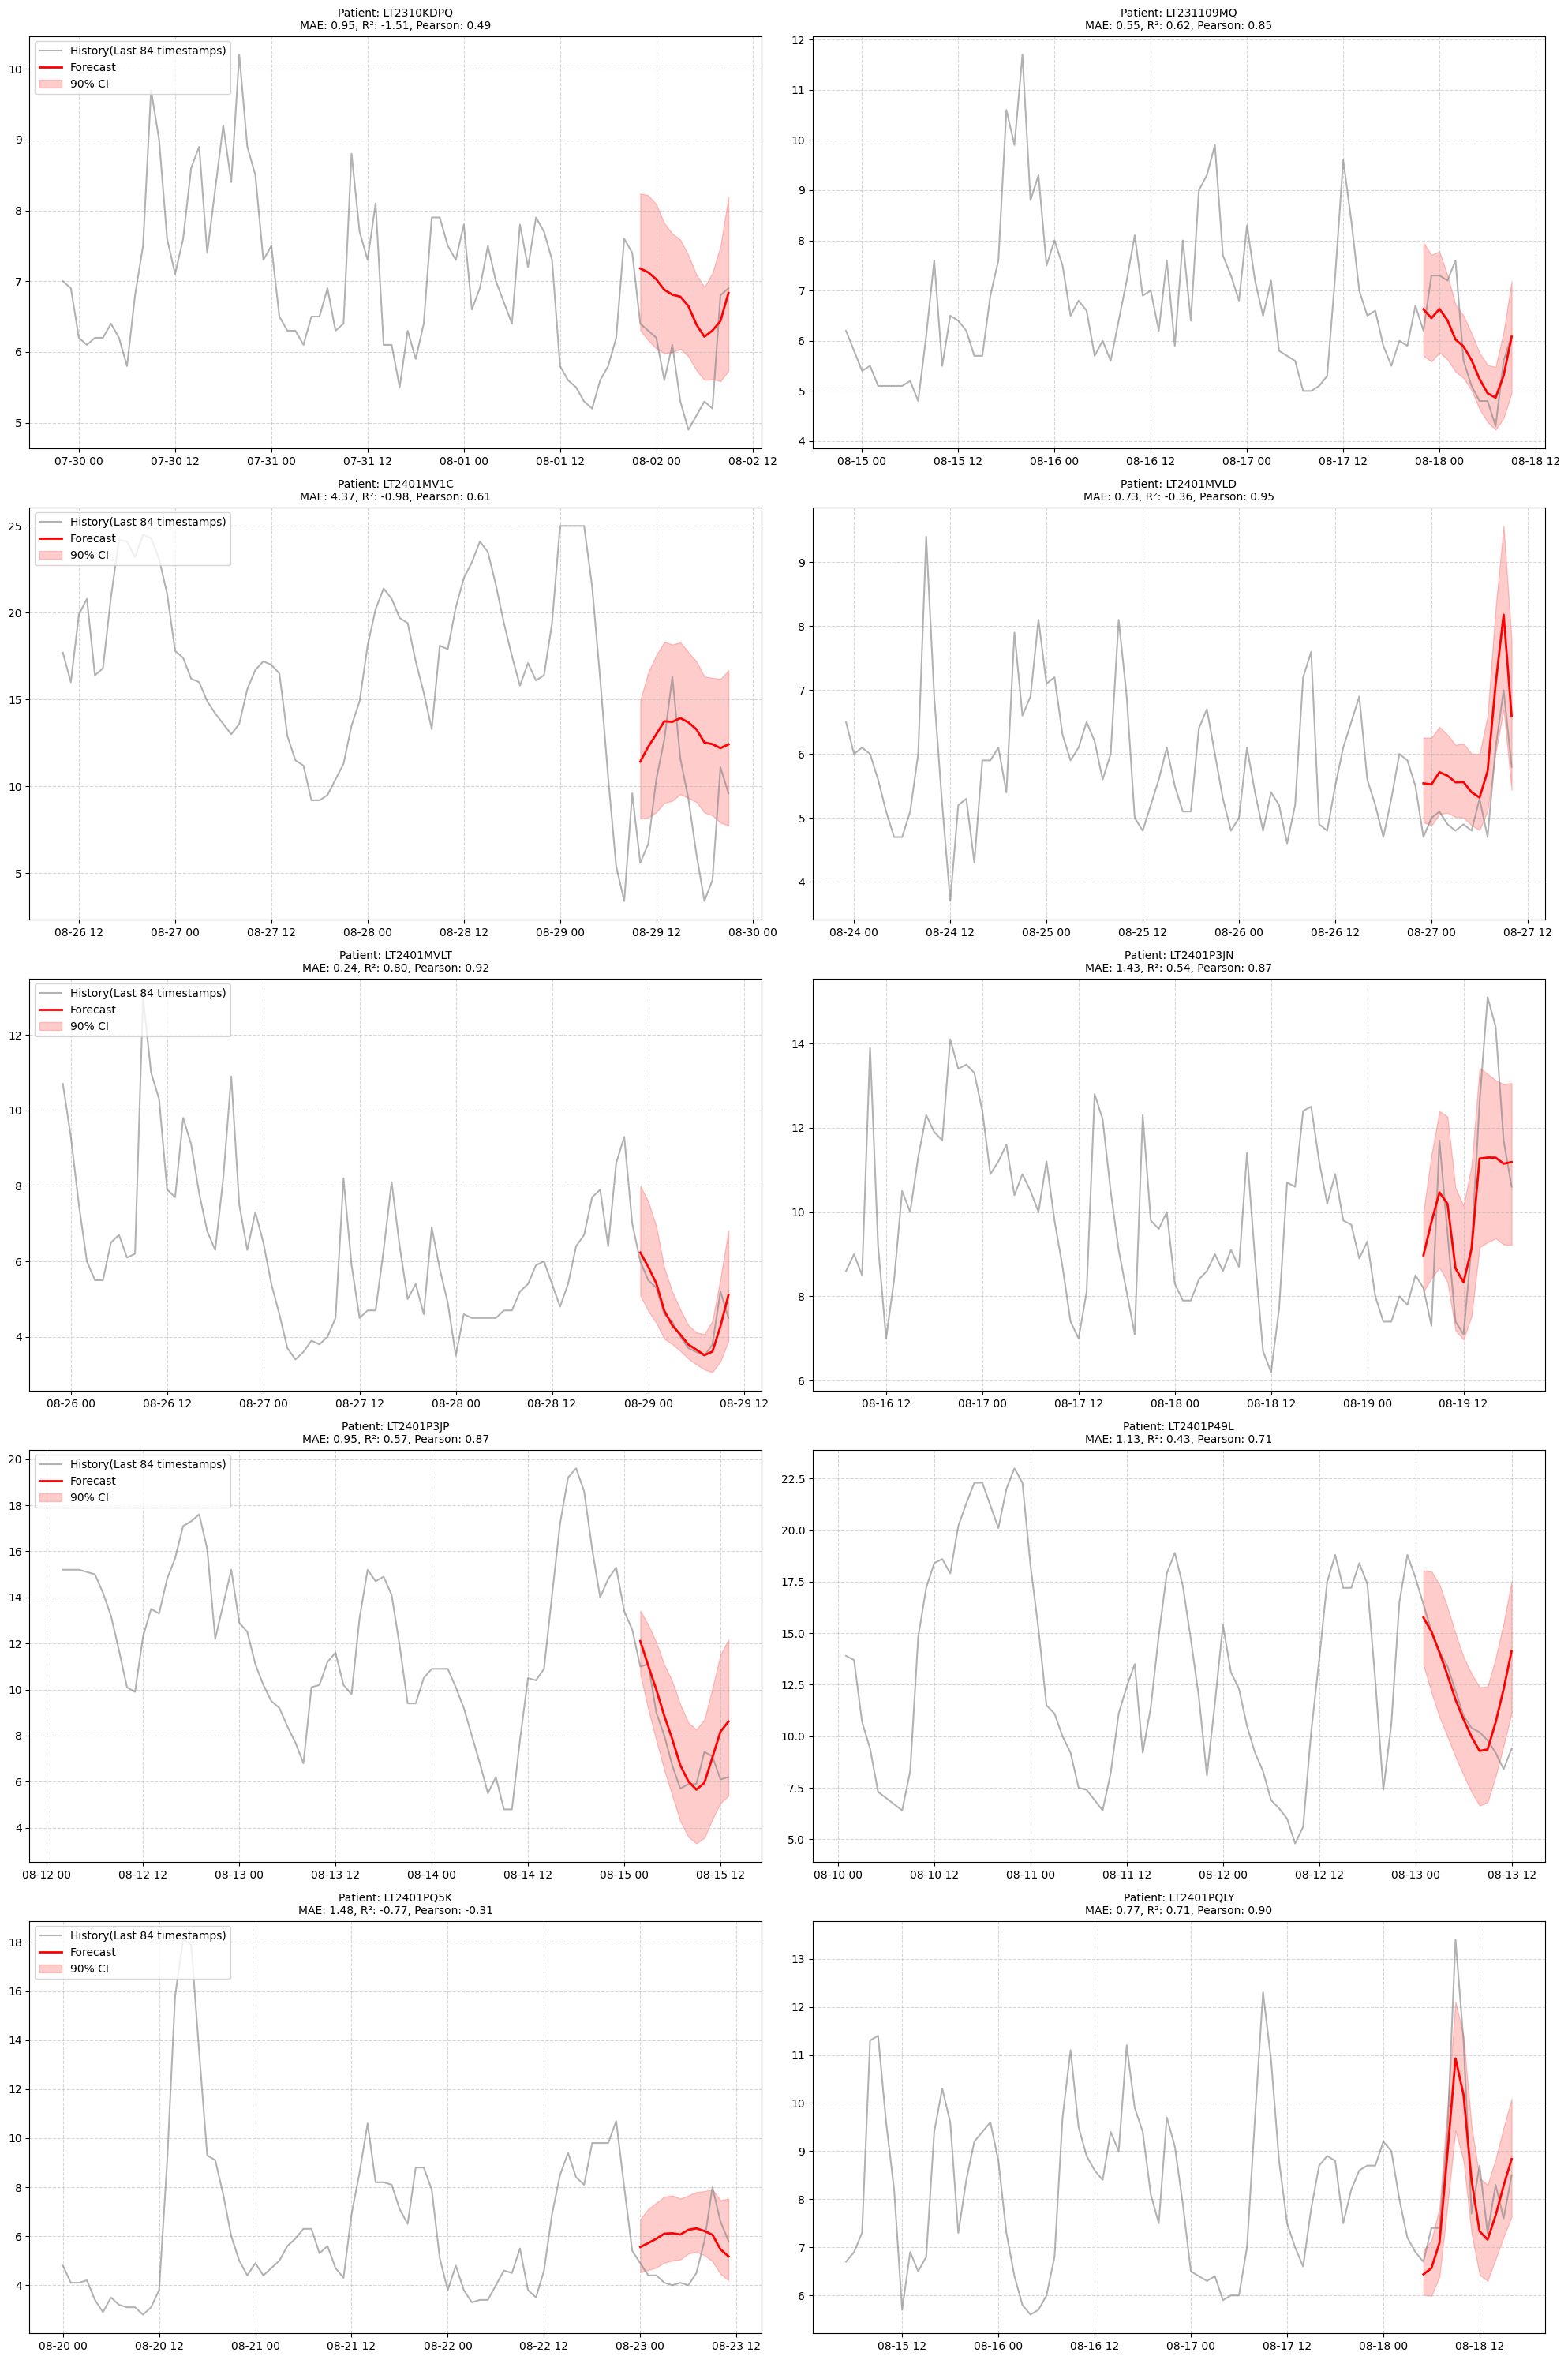

Average MAE: 1.26
Average MSE: 3.98
Average R²: 0.01
Average Pearson: 0.69


In [59]:
# 计算MAE，MSE，r2_score, Pearson相关系数
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from math import ceil
import matplotlib.pyplot as plt


item_ids = data.index.get_level_values('item_id').unique()

# 图像设置
n_patients = len(item_ids)
n_rows = ceil(n_patients / 2)
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
axes = axes.flatten()
TIMESTAMPS = 84 

mae, mse, r2, pearson = [], [], [], []

for i, unique_id in enumerate(item_ids):
    patient_data = data[data.index.get_level_values('item_id') == unique_id]
    patient_predictions = predictions[predictions.index.get_level_values('item_id') == unique_id]
    test_patient_data = patient_data.iloc[-prediction_length:]
    
    mae_val = mean_absolute_error(test_patient_data['target'], patient_predictions['mean'])
    mse_val = mean_squared_error(test_patient_data['target'], patient_predictions['mean'])
    r2_val = r2_score(test_patient_data['target'], patient_predictions['mean'])
    pearson_val = pearsonr(test_patient_data['target'], patient_predictions['mean'])[0]
    
    mae.append(mae_val)
    mse.append(mse_val)
    r2.append(r2_val)
    pearson.append(pearson_val)
    
    # ------------------------- 绘制子图 -------------------------
    ax = axes[i]
    
    # 绘制历史数据（灰色）
    ax.plot(
        patient_data.index.get_level_values('timestamp')[-TIMESTAMPS:],
        patient_data['target'].values[-TIMESTAMPS:],
        label='History(Last {} timestamps)'.format(TIMESTAMPS),
        color='gray',
        alpha=0.6
    )
    
    # 绘制预测数据（红色）
    ax.plot(
        patient_predictions.index.get_level_values('timestamp'),
        patient_predictions['mean'],
        label='Forecast',
        color='red',
        linewidth=2
    )
    
    # 绘制置信区间（红色透明区域）
    if '0.1' in patient_predictions.columns and '0.9' in patient_predictions.columns:
        ax.fill_between(
            patient_predictions.index.get_level_values('timestamp'),
            patient_predictions['0.1'],
            patient_predictions['0.9'],
            color='red',
            alpha=0.2,
            label='90% CI'
        )
    
    # 添加标题和标签
    ax.set_title(
        f"Patient: {unique_id}\n"
        f"MAE: {mae_val:.2f}, R²: {r2_val:.2f}, Pearson: {pearson_val:.2f}",
        fontsize=10
    )
    ax.set_xlabel('')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 仅在第一列和最右侧子图显示图例
    if i % 2 == 0:
        ax.legend(loc='upper left')

# 隐藏多余的子图（当患者数量为奇数时）
for j in range(n_patients, n_rows * n_cols):
    axes[j].axis('off')


plt.tight_layout()
plt.show()


print(f"Average MAE: {sum(mae)/len(mae):.2f}")
print(f"Average MSE: {sum(mse)/len(mse):.2f}")
print(f"Average R²: {sum(r2)/len(r2):.2f}")
print(f"Average Pearson: {sum(pearson)/len(pearson):.2f}")

In [ ]:
print(predictions)